# Jawaban UTS Deep Learning
## Nama : Jessica Priscilla Immanuel
## NIM  : 2702246163

## **Nomor 1 - Deep learning for room temperature prediction**

### 1. Connect ke Google Drive dulu karena memakai Google Collab
Kalau menggunakan VSCode laptop saya tidak kuat, jadi saya memakai Google Collab.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### 2. Cek Dataset yang dipakai dengan NIM saya (2702246163)

In [ ]:
student_id = "2702246163"

import hashlib
student_id_hash = int(hashlib.md5(student_id.encode('utf-8')).hexdigest(), 16)

In [ ]:
location_int = student_id_hash % 3

if location_int==0:
    location = 'A'
    max_file = 60
elif location_int==1:
    location = 'B'
    max_file = 44
elif location_int==2:
    location = 'C'
    max_file = 40

In [ ]:
file_id = student_id_hash % (max_file-1)

In [ ]:
print(f"""Please use the following files:
    * Room-Climate-Datasets/datasets-location_{location}/room_climate-location_{location}-measurement{file_id:02d}.csv
    * Room-Climate-Datasets/datasets-location_{location}/room_climate-location_{location}-measurement{file_id+1:02d}.csv
""")

Please use the following files:
    * Room-Climate-Datasets/datasets-location_A/room_climate-location_A-measurement40.csv
    * Room-Climate-Datasets/datasets-location_A/room_climate-location_A-measurement41.csv



## **a. Construct and train a deep learning model with temperature, relative humidity, light sensor 1, and light sensor 2 as input, and the temperature of the next timestamp (next row in the csv files) as the label. You can set each of the hyperparameters to any value**

### 3. Import library yang akan digunakan pada nomor 1

In [86]:
!pip install keras_tuner

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.4/129.4 kB 3.5 MB/s eta 0:00:00


In [165]:
# import library
import glob
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import keras_tuner as kt
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler

### 4. Menambahkan header ke setiap kolom
Sebelumnya kolom belum memiliki header, sehingga perlu saya tambahkan dan save ke file .csv yang baru. Nama setiap header didapatkan dari informasi dataset yang ada di github (https://github.com/wawancenggoro/Room-Climate-Datasets). Header yang ditambahkan secara berurutan, yaitu:
1. EID, Entry ID
2. AbsT, Absolute timestamp [ms]
3. RelT, Relative timestamp [s]
4. NID, Node ID
5. Sensor Data:

    a. Temp, Temperature (°C)

    b. RelH, Relative Humidity (%)

    c. L1, Light Sensor 1 (Wavelength) [nm]

    d. L2, Light Sensor 2 (Wavelength) [nm]

6. Groundtruth:

    a. Occ, Number of occupants (0, 1, 2)

    b. Act, Activity of occupant(s) (0 = n/a, 1 = read, 2 = stand, 3 = walk, 4 = work).

    c. Door, State of Door (0 = closed, 1 = open)
    
    d. Win, State of Window (0 = closed, 1 = open)

Total ada 12 fitur.

In [166]:
def add_header_to_csv(input_file):
    # nama kolom
    columns = [
        "EID", "AbsT", "RelT", "NID", "Temp", "RelH", "L1", "L2", "Occ", "Act", "Door", "Win"
    ]

    # read file yang kita punya dan tambah kolomnya
    df = pd.read_csv(input_file, sep=',', header=None, names=columns)

    # cek 5 baris paling awal
    print(f"Head data {input_file}: \n")
    print(f"{df.head()}\n")

    return df

# path ke file yang mau ditambah header nya
filename1 = "/content/drive/My Drive/Semester 5/UTS Deep Learning/data/room_climate-location_A-measurement40.csv"
filename2 = "/content/drive/My Drive/Semester 5/UTS Deep Learning/data/room_climate-location_A-measurement41.csv"

# tambah header
data1 = add_header_to_csv(filename1)
data2 = add_header_to_csv(filename2)

# save ke file baru yang sudah ada header
data1.to_csv("with_header_room_climate-location_A-measurement40.csv", sep='\t', index=False)
data2.to_csv("with_header_room_climate-location_A-measurement41.csv", sep='\t', index=False)

Head data /content/drive/My Drive/Semester 5/UTS Deep Learning/data/room_climate-location_A-measurement40.csv: 

   EID           AbsT  RelT  NID   Temp    RelH      L1      L2  Occ  Act  \
0    1  1459776930261     2    3  22.66  51.890  242.86   855.6    0    0   
1    2  1459776931979     3    1  22.66  55.819  220.00   708.4    0    0   
2    3  1459776932247     3    4  23.11  52.578  271.43  1067.2    0    0   
3    4  1459776932290     4    2  22.92  54.077  237.14   864.8    0    0   
4    5  1459776934376     6    3  22.64  51.890  241.43   855.6    0    0   

   Door  Win  
0     0    0  
1     0    0  
2     0    0  
3     0    0  
4     0    0  

Head data /content/drive/My Drive/Semester 5/UTS Deep Learning/data/room_climate-location_A-measurement41.csv: 

   EID           AbsT  RelT  NID   Temp    RelH      L1      L2  Occ  Act  \
0    1  1459781778472     2    3  22.96  52.416  338.57  1656.0    0    0   
1    2  1459781779460     3    2  23.26  54.563  341.43  1784.8   

In [167]:
# cek file yang sudah saya update memiliki header di setiap kolom
drive_file_path = '/content/drive/My Drive/Semester 5/UTS Deep Learning/data/data_header/with_header_room_climate-location_A-measurement40.csv'

try:
    df_drive = pd.read_csv(drive_file_path)
    print(f"Successfully loaded data from {drive_file_path}")
    display(df_drive.head())
except FileNotFoundError:
    print(f"Error: The file '{drive_file_path}' was not found.")
except Exception as e:
    print(f"An error occurred: {e}")

Successfully loaded data from /content/drive/My Drive/Semester 5/UTS Deep Learning/data/data_header/with_header_room_climate-location_A-measurement40.csv


,EID\tAbsT\tRelT\tNID\tTemp\tRelH\tL1\tL2\tOcc\tAct\tDoor\tWin
0,1\t1459776930261\t2\t3\t22.66\t51.89\t242.86\t...
1,2\t1459776931979\t3\t1\t22.66\t55.819\t220.0\t...
2,3\t1459776932247\t3\t4\t23.11\t52.578\t271.43\...
3,4\t1459776932290\t4\t2\t22.92\t54.077\t237.14\...
4,5\t1459776934376\t6\t3\t22.64\t51.89\t241.43\t...


### 5. Gabungkan 2 file yang ada untuk dataset

In [168]:
data = "/content/drive/My Drive/Semester 5/UTS Deep Learning/data/data_header/"

# cek file
all_csv_files = glob.glob(os.path.join(data, "*.csv"))
print("Ada file CSV di folder:")
for f in all_csv_files:
    print("-", f)

if not all_csv_files:
    print("Tidak ada file CSV di folder.", data)
else:
    # baca semua file csv yg ada di folder
    dataframes = []
    for file in all_csv_files:
        df = pd.read_csv(file, sep="\t")
        dataframes.append(df)

    # gabungin file 1 dan 2
    df12 = pd.concat(dataframes, ignore_index=True)

    print("Total data gabungan:", len(df12))
    display(df12.head())


Ada file CSV di folder:
- /content/drive/My Drive/Semester 5/UTS Deep Learning/data/data_header/with_header_room_climate-location_A-measurement40.csv
- /content/drive/My Drive/Semester 5/UTS Deep Learning/data/data_header/with_header_room_climate-location_A-measurement41.csv
Total data gabungan: 6658


,EID,AbsT,RelT,NID,Temp,RelH,L1,L2,Occ,Act,Door,Win
0,1,1459776930261,2,3,22.66,51.890,242.86,855.6,0,0,0,0
1,2,1459776931979,3,1,22.66,55.819,220.00,708.4,0,0,0,0
2,3,1459776932247,3,4,23.11,52.578,271.43,1067.2,0,0,0,0
3,4,1459776932290,4,2,22.92,54.077,237.14,864.8,0,0,0,0
4,5,1459776934376,6,3,22.64,51.890,241.43,855.6,0,0,0,0


### 6. Preprocessing data

In [169]:
# copy df yg awal ke variable baru
df = df12

# hapus spasi yang kelebihan
df = df.rename(columns={c: c.strip() for c in df.columns})

# urutin berdasarkan NID dan AbsT
df = df.sort_values(["NID", "AbsT"]).reset_index(drop=True)

# hapus data yang kosong karena kita butuh yg ada isi aja
df = df.dropna(subset=["Temp","RelH","L1","L2"])

# typecast menjadi string
df["NID"] = df["NID"].astype(str)

In [170]:
df

,EID,AbsT,RelT,NID,Temp,RelH,L1,L2,Occ,Act,Door,Win
0,2,1459776931979,3,1,22.66,55.819,220.00,708.4,0,0,0,0
1,6,1459776935719,7,1,22.66,55.819,220.00,708.4,0,0,0,0
2,11,1459776940084,11,1,22.65,55.819,220.00,708.4,0,0,0,0
3,16,1459776944314,16,1,22.64,55.819,221.43,713.0,0,0,0,0
4,20,1459776948304,20,1,22.66,55.819,220.00,708.4,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
6653,2440,1459784216591,2440,4,23.52,53.753,348.57,1899.8,0,0,0,0
6654,2442,1459784219570,2443,4,23.51,53.794,351.43,1881.4,0,0,0,0
6655,2448,1459784224206,2448,4,23.53,53.834,345.71,1876.8,0,0,0,0
6656,2450,1459784227550,2451,4,23.53,53.874,350.00,1876.8,0,0,0,0


In [171]:
# kita cuma pakai temp, relh, l1, l2 untuk inputnya
input = ["Temp","RelH","L1","L2"]

# bikin kolom baru buat temperature selanjutnya
df['Temp_Next'] = df.groupby('NID')['Temp'].shift(-1)

# drop Temp_next yg kosong
df_clean = df.dropna(subset=["Temp_Next"]).reset_index(drop=True)

# pisahin jd input dan label/target nya
# x = input, y = target
x = df_clean[input].values
y = df_clean['Temp_Next'].values.reshape(-1, 1)

# cek shape
x.shape, y.shape

((6654, 4), (6654, 1))

In [133]:
df_clean

,EID,AbsT,RelT,NID,Temp,RelH,L1,L2,Occ,Act,Door,Win,Temp_Next
0,2,1459776931979,3,1,22.66,55.819,220.00,708.4,0,0,0,0,22.66
1,6,1459776935719,7,1,22.66,55.819,220.00,708.4,0,0,0,0,22.65
2,11,1459776940084,11,1,22.65,55.819,220.00,708.4,0,0,0,0,22.64
3,16,1459776944314,16,1,22.64,55.819,221.43,713.0,0,0,0,0,22.66
4,20,1459776948304,20,1,22.66,55.819,220.00,708.4,0,0,0,0,22.65
...,...,...,...,...,...,...,...,...,...,...,...,...,...
6649,2436,1459784211860,2435,4,23.52,53.753,351.43,1890.6,0,0,0,0,23.52
6650,2440,1459784216591,2440,4,23.52,53.753,348.57,1899.8,0,0,0,0,23.51
6651,2442,1459784219570,2443,4,23.51,53.794,351.43,1881.4,0,0,0,0,23.53
6652,2448,1459784224206,2448,4,23.53,53.834,345.71,1876.8,0,0,0,0,23.53


### 7. Splitting data

In [172]:
# splitting 80:20
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

In [173]:
# normalization
scaler_x = StandardScaler()
scaler_y = StandardScaler()

x_train_scaler = scaler_x.fit_transform(x_train)
x_test_scaler = scaler_x.transform(x_test)

y_train_scaler = scaler_y.fit_transform(y_train)
y_test_scaler = scaler_y.transform(y_test)

In [174]:
# n_samples, n_features
print(x_train_scaler.shape)
print(x_test_scaler.shape)
print(y_train_scaler.shape)
print(y_test_scaler.shape)

(5323, 4)
(1331, 4)
(5323, 1)
(1331, 1)


In [175]:
# reshape ke lstm
# samples, timesteps, features
x_train_scaler = x_train_scaler.reshape((x_train_scaler.shape[0], 1, x_train_scaler.shape[1]))
x_test_scaler = x_test_scaler.reshape((x_test_scaler.shape[0], 1, x_test_scaler.shape[1]))

### 8. Modelling

In [176]:
import tensorflow as tf

# modelling lstm
model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(1, 4)),
    tf.keras.layers.LSTM(32, return_sequences=False),
    tf.keras.layers.Dense(16, activation="relu"),
    tf.keras.layers.Dense(1)
])

metricss = [tf.keras.metrics.RootMeanSquaredError()]
model.compile(optimizer='adam', loss='mse', metrics=metricss)
# model.compile(optimizer='adam', loss='mse', metrics=['accuracy'])
model.summary()

Model: "sequential_14"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_14 (LSTM)                  │ (None, 32)             │         4,736 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_28 (Dense)                │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_29 (Dense)                │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,281 (20.63 KB)

 Trainable params: 5,281 (20.63 KB)

 Non-trainable params: 0 (0.00 B)

### 9. Training

In [177]:
early_stop = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True)
history = model.fit(x_train_scaler, y_train_scaler, validation_data=(x_test_scaler, y_test_scaler), epochs=25, batch_size=64, verbose=2, callbacks=[early_stop])

Epoch 1/25
84/84 - 3s - 30ms/step - loss: 0.7304 - root_mean_squared_error: 0.8547 - val_loss: 0.3685 - val_root_mean_squared_error: 0.6071
Epoch 2/25
84/84 - 0s - 4ms/step - loss: 0.1381 - root_mean_squared_error: 0.3717 - val_loss: 0.0246 - val_root_mean_squared_error: 0.1568
Epoch 3/25
84/84 - 1s - 8ms/step - loss: 0.0147 - root_mean_squared_error: 0.1212 - val_loss: 0.0092 - val_root_mean_squared_error: 0.0961
Epoch 4/25
84/84 - 0s - 4ms/step - loss: 0.0076 - root_mean_squared_error: 0.0871 - val_loss: 0.0067 - val_root_mean_squared_error: 0.0821
Epoch 5/25
84/84 - 0s - 4ms/step - loss: 0.0057 - root_mean_squared_error: 0.0757 - val_loss: 0.0053 - val_root_mean_squared_error: 0.0731
Epoch 6/25
84/84 - 0s - 4ms/step - loss: 0.0046 - root_mean_squared_error: 0.0677 - val_loss: 0.0042 - val_root_mean_squared_error: 0.0648
Epoch 7/25
84/84 - 0s - 4ms/step - loss: 0.0036 - root_mean_squared_error: 0.0601 - val_loss: 0.0033 - val_root_mean_squared_error: 0.0578
Epoch 8/25
84/84 - 0s - 4m

### 10. Evaluate

42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
Validation RMSE: 0.0090 °C


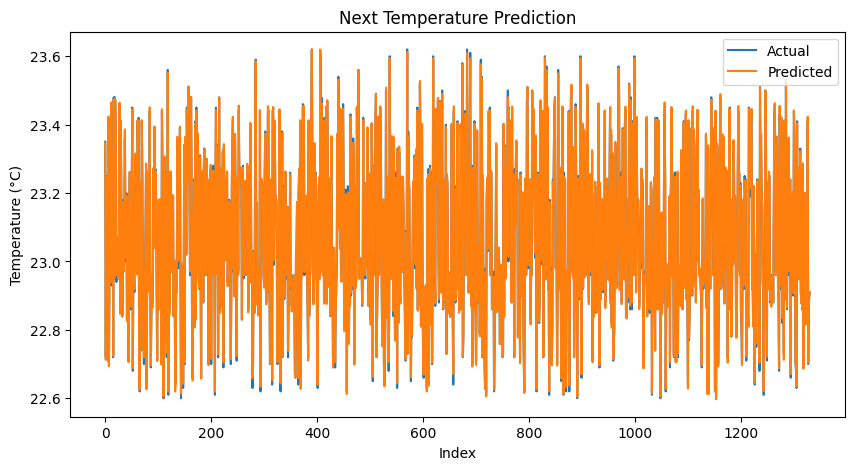

In [194]:
y_pred_scaler = model.predict(x_test_scaler)
y_pred = scaler_y.inverse_transform(y_pred_scaler)
rmse = np.sqrt(np.mean((y_pred.flatten() - y_test.flatten())**2))
print(f"Validation RMSE: {rmse:.4f} °C")

# ---- PLOT SAMPLE ----
plt.figure(figsize=(10,5))
plt.plot(y_test, label="Actual")
plt.plot(y_pred, label="Predicted")
plt.legend()
plt.title("Next Temperature Prediction")
plt.xlabel("Index")
plt.ylabel("Temperature (°C)")
plt.show()

## **b. Plot the training and validation losses over epochs, analyze and explain what happens in the training based on the plot.**

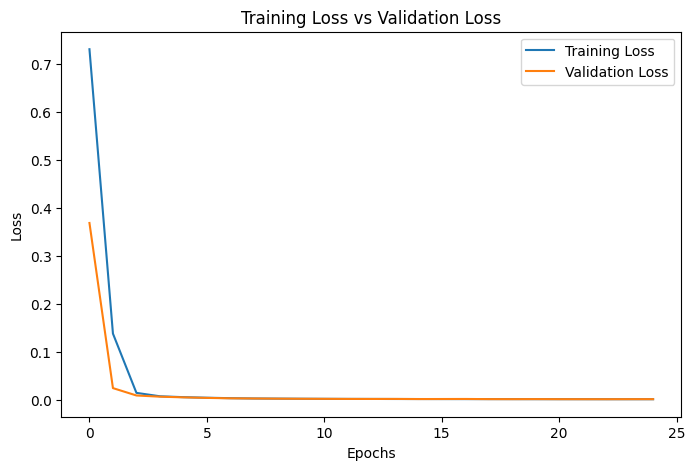

In [179]:
plt.figure(figsize=(8,5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training Loss vs Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


Pada dasarnya hasil yang baik adalah training loss dan validation loss harus menurun bersamaan sehingga akhirnya memiliki grafik garis lurus datar. Dapat disimpulkan dari hasil plot training loss dan validation loss, bahwa:
*   Model dapat belajar dengan baik saat training
*   Model tidak mengalami overfitting ataupun underfitting
Ketika sudah terlihat stabil, training bisa diselesaikan. Saya pakai early stopping untuk bisa langsung stop training setelah sudah stabil.

Dari hasil plotting dapat diketahui, bahwa:
*   Epoch 0–5, model mulai belajar pola
*   Epoch 10–20, model sudah mengerti polanya

## **c. Do hyperparameter tuning to improve the deep learning model based on the result of point b and any other results you get from the training process.**

In [184]:
def build_model(hp):
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Input(shape=(1, 4)))

    # tuning jumlah unit LSTM
    hp_units = hp.Int('lstm_units', min_value=16, max_value=128, step=16)
    model.add(tf.keras.layers.LSTM(hp_units, return_sequences=False))

    # dropout supaya tidak overfitting
    hp_dropout = hp.Float('dropout_rate', min_value=0.0, max_value=0.5, step=0.1)
    model.add(tf.keras.layers.Dropout(hp_dropout))

    # dense
    hp_dense = hp.Int('dense_units', min_value=8, max_value=64, step=8)
    model.add(tf.keras.layers.Dense(hp_dense, activation='relu'))

    # output layer
    model.add(tf.keras.layers.Dense(1))

    # optimizer tuning
    hp_learning_rate = hp.Choice('learning_rate', [1e-2, 1e-3, 5e-4])
    optimizer = tf.keras.optimizers.Adam(learning_rate=hp_learning_rate)

    metricss = [tf.keras.metrics.RootMeanSquaredError()]
    model.compile(optimizer=optimizer, loss='mse', metrics=metricss)
    # model.compile( optimizer=optimizer, loss='mse', metrics=['accuracy'])
    return model

# tuner setup, hyperband
tuner = kt.Hyperband(build_model, objective='val_root_mean_squared_error', max_epochs=30, factor=3, directory='tuning_results', project_name='room_temp_tuning')

Reloading Tuner from tuning_results/room_temp_tuning/tuner0.json


In [185]:
# run tuning
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)
tuner.search(x_train_scaler, y_train_scaler, validation_data=(x_test_scaler, y_test_scaler), epochs=10, batch_size=64, callbacks=[early_stop], verbose=2)

# ambil best model
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

# cek yg terbaik
print(f"""
Best hyperparameters:
- LSTM units   : {best_hps.get('lstm_units')}
- Learning rate: {best_hps.get('learning_rate')}
- Dense units  : {best_hps.get('dense_units')}
- Dropout rate : {best_hps.get('dropout_rate')}
""")


Best hyperparameters:
- LSTM units   : 80
- Learning rate: 0.01
- Dense units  : 56
- Dropout rate : 0.0



In [186]:
# train ulang dengan best model
best_model = tuner.hypermodel.build(best_hps)

early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=6, restore_best_weights=True)
history_best = best_model.fit(x_train_scaler, y_train_scaler, validation_data=(x_test_scaler, y_test_scaler), epochs=50, batch_size=64, verbose=2, callbacks=[early_stop])

Epoch 1/50
84/84 - 3s - 31ms/step - loss: 0.0547 - root_mean_squared_error: 0.2339 - val_loss: 0.0023 - val_root_mean_squared_error: 0.0482
Epoch 2/50
84/84 - 0s - 5ms/step - loss: 0.0018 - root_mean_squared_error: 0.0429 - val_loss: 0.0019 - val_root_mean_squared_error: 0.0439
Epoch 3/50
84/84 - 0s - 5ms/step - loss: 0.0017 - root_mean_squared_error: 0.0409 - val_loss: 0.0015 - val_root_mean_squared_error: 0.0392
Epoch 4/50
84/84 - 0s - 5ms/step - loss: 0.0018 - root_mean_squared_error: 0.0424 - val_loss: 0.0021 - val_root_mean_squared_error: 0.0459
Epoch 5/50
84/84 - 0s - 5ms/step - loss: 0.0016 - root_mean_squared_error: 0.0404 - val_loss: 0.0017 - val_root_mean_squared_error: 0.0416
Epoch 6/50
84/84 - 0s - 5ms/step - loss: 0.0016 - root_mean_squared_error: 0.0400 - val_loss: 0.0018 - val_root_mean_squared_error: 0.0421
Epoch 7/50
84/84 - 0s - 5ms/step - loss: 0.0018 - root_mean_squared_error: 0.0422 - val_loss: 0.0015 - val_root_mean_squared_error: 0.0393
Epoch 8/50
84/84 - 0s - 5m

42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
Improved Validation RMSE: 0.0084 °C


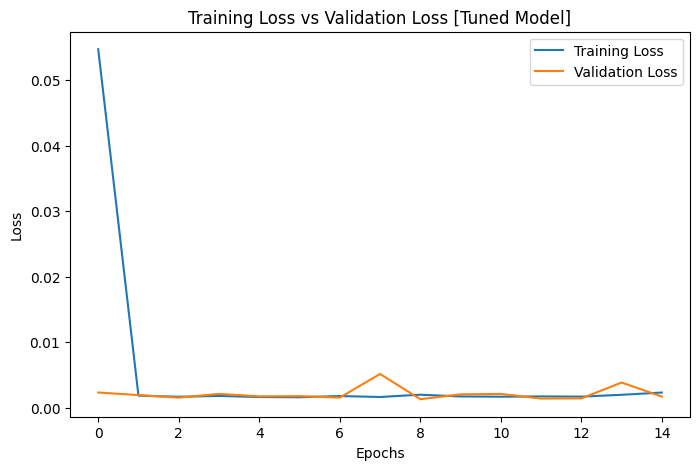

In [187]:
# evaluasi ulang
y_pred_best = best_model.predict(x_test_scaler)
y_pred_best_inv = scaler_y.inverse_transform(y_pred_best)
rmse_best = np.sqrt(np.mean((y_pred_best_inv.flatten() - y_test.flatten())**2))
print(f"Improved Validation RMSE: {rmse_best:.4f} °C")

# plot ulang
plt.figure(figsize=(8,5))
plt.plot(history_best.history['loss'], label='Training Loss')
plt.plot(history_best.history['val_loss'], label='Validation Loss')
plt.title('Training Loss vs Validation Loss [Tuned Model]')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

Dari hasil yang ada dapat disimpulkan bahwa hyperparameters tuning terbaik yang dipilih otomatis oleh tuner adalah LSTM 80 units, Dense Unit 56, dropout 0.0, dan learning rate 0.01.

Validation RMSE sekarang lebih rendah, yaitu 0.0084 °C. Sebelumnya 0.0090 °C.

## **d. Test the model on a separate test set with appropriate metrics**

In [160]:
# prediksi di test set
y_test_pred_scaler = best_model.predict(x_test_scaler)
y_test_pred = scaler_y.inverse_transform(y_test_pred_scaler)

# evaluation
mae = mean_absolute_error(y_test, y_test_pred)
mse = mean_squared_error(y_test, y_test_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_test_pred)

print("Model Evaluation on Test Set")
print("=========================================")
print(f"Mean Absolute Error (MAE)     : {mae:.4f}°C")
print(f"Mean Squared Error (MSE)      : {mse:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}°C")
print(f"R² Score                      : {r2:.4f}")


42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Model Evaluation on Test Set
Mean Absolute Error (MAE)     : 0.0065°C
Mean Squared Error (MSE)      : 0.0001
Root Mean Squared Error (RMSE): 0.0085°C
R² Score                      : 0.9987


Dari hasil evaluasi diatas dapat diketahui:
* Rata-rata kesalahan nya sangat kecil.
* Prediksi dari model yang ada sudah hampir sempurna dengan R2 Score yang mencapai 0.9987.

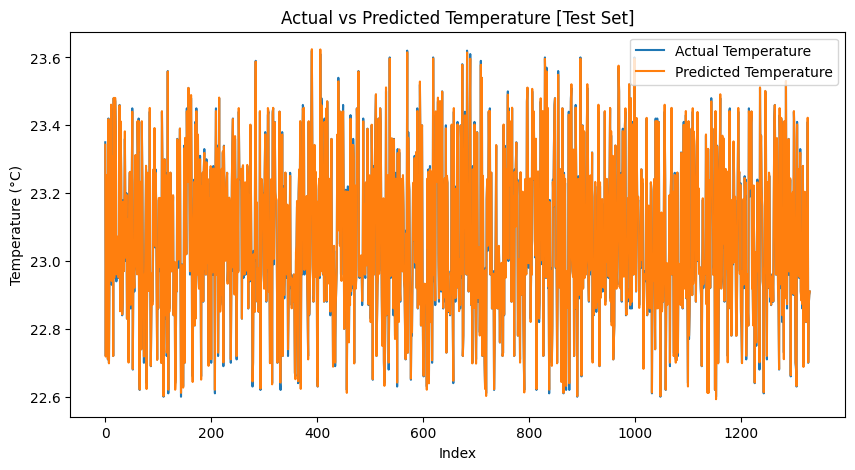

In [195]:
# plotting
plt.figure(figsize=(10,5))
plt.plot(y_test, label='Actual Temperature')
plt.plot(y_test_pred, label='Predicted Temperature')
plt.title("Actual vs Predicted Temperature [Test Set]")
plt.xlabel("Index")
plt.ylabel("Temperature (°C)")
plt.legend()
plt.show()